In [11]:
# new test with updated database and classifier using different processing method
# stopped on the 6 march - couldn't get it to work - look at pmc development might be
# possible to get something to work there

import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug', '/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev', '/Users/david/Documents/mastersCode/ubm/classifiers/hmm_pmc/development', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm', '/Users/david/Documents/mastersCode/ubm']


In [12]:
from importlib import reload
import audio_datastore.audio_datastore as myads
reload(myads)
from importlib import reload
from collections import Counter
import pickle
import time

Using cache found in /Users/david/.cache/torch/hub/snakers4_silero-vad_master


In [13]:
from data.pitch_tracking_database.load_data import *
speech_pitch_tracking_db = pickle.load(open(normalised_30,'rb'))
ads = speech_pitch_tracking_db['ads']

In [14]:
# split ads
developmentLabels = ["M03","M04","M05","M06","M07","M08","M09","M10","F05","F06","F07","F08","F09","F10",
                     "F03","F04"]
evaluationLabels = ["M01","M02","F01","F02"]
adsTrain = myads.subset(ads, developmentLabels)
adsEvaluate = myads.subset(ads, evaluationLabels)
numFilesPerSpeakerForEnrollment = 20
adsEnroll, adsDet = myads.split(adsEvaluate, numFilesPerSpeakerForEnrollment)
adsTest = adsDet
# adsDet, adsTest = myads.split(adsDet, 2)
adsTrain.info('Train')
adsEnroll.info('Enroll')
adsTest.info('Test')

Train database info: 
dict_keys(['F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'M03', 'M04', 'M05', 'M06', 'M07', 'M08', 'M09', 'M10'])
dict_values([30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30])


Enroll database info: 
dict_keys(['F01', 'F02', 'M01', 'M02'])
dict_values([20, 20, 20, 20])


Test database info: 
dict_keys(['F01', 'F02', 'M01', 'M02'])
dict_values([10, 10, 10, 10])




In [15]:
from classifiers.classifier_base import ClassifierBase
import classifiers.hmm_pmc.classifier_hmm_pmc as pmc
reload(pmc)
from my_torch.tuts2.torch_transforms import ComposeTransform

def test_classifiers(ads_train, ads_test, classifiers: [pmc.ClassifierHMMPMC], verbose=False):
    index = 1
    if verbose:
        print('running all')

    for classifier in classifiers:
        if verbose:
            print('\n')
            print('test #', index)
        print(classifier.info)

        classifier.train(ads_train)
        classifier.train_noise_hmm()
        classifier.adapt_speaker_models()
        classifier.test_all(ads_test)

        index = index + 1
        if verbose:
            print('\n')

In [16]:
from feature_extraction.fe_spafe.fe_spafe import FeatureExtractorMfcc
import my_torch.tuts2.torch_transforms as torch_t
reload(torch_t)

fe_mfcc = FeatureExtractorMfcc()
fe_mfcc.set_normalisation(adsDet)
snr = 2

classifier_a = pmc.ClassifierHMMPMC(
    train_process=torch_t.ComposeProcessTransform([]),
    test_process=torch_t.ComposeProcessTransform([torch_t.AddGaussianWhiteNoise(20)]),
    fe_method=torch_t.ComposeTransform([
    fe_mfcc,
    ]),
    snr=snr,
    signal_average_power=ads.average_power,
    info='base mfcc with - no noise'
)

running all


test # 1
2
input vector shape incorrect


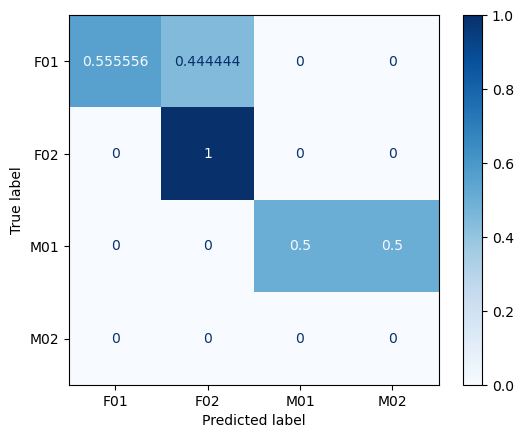

In [17]:
test_classifiers(adsEnroll, adsTest, [classifier_a], verbose=True)